# Shape from Silhouette With Rays
Compare to PyTorch3D `Fit a mesh with texture` sample. We only use a silhouette loss (PyTorch sample uses color, silhouette, edge, normal and laplacian loss terms). In our testing, this runs about 1,000x faster than the PyTorch  example on our CPU hardware, although it doesn't reconstruct color. 

This example differs from the other in that camera poses are implicitly stored in the camera rays data structure and there is no traditional pose optimization possible. However, here we can run simple (no batch) gradient descent on the entire dataset at once, which should be faster for large parallel computers.

In [1]:
import os
import sys

import torch

import numpy as np
import matplotlib.pyplot as plt

from util import image_grid

In [2]:
%matplotlib inline

In [3]:
import trimesh
import pyrender
import transforms3d

from tqdm.notebook import tqdm

# Load data and generate views with TriMesh and PyRender
we're using the cow model from Keenan Crane, featured in the PyTorch3D tutorials

In [4]:
mesh_file = 'data/cow.obj'

mesh_tri = trimesh.load(mesh_file)

# seems sane to fetch/estimate scale
shape_scale = float(mesh_tri.vertices.std(0).mean())*3
center = np.array(mesh_tri.vertices.mean(0))
print('model is {:.2f}x the size of the cow'.format(shape_scale/1.18))

model is 1.00x the size of the cow


In [5]:
import time
os.environ['DISPLAY'] = ':1'

num_views = 20
image_size = (64,64)
vfov_degrees = 45
# this balances covariance and mean optimization due to using Adam
opt_shape_scale = 2.2
shape_scale_mul = opt_shape_scale/shape_scale

focal_length = 0.5*image_size[0]/np.tan((np.pi/180.0)*vfov_degrees/2)
cx = (image_size[1]-1)/2
cy = (image_size[0]-1)/2

np.random.seed(42)
rand_quats = np.random.randn(num_views,4)

# Optionally perturb around current set of views
rand_perturb_count = 20
rand_perturb_scale = 0.1
rand_perturb = False
if rand_perturb:
    rand_quats = rand_quats[:, None, :] + np.random.randn(rand_perturb_count,4)[None, :, :] * rand_perturb_scale
    rand_quats = rand_quats.reshape(-1, 4)

rand_quats = rand_quats/np.linalg.norm(rand_quats,axis=1,keepdims=True)

mesh = pyrender.Mesh.from_trimesh(mesh_tri)

ref_colors = []
ref_depths = []
scene = pyrender.Scene()
scene.add(mesh)

trans = []
for quat in rand_quats:

    R = transforms3d.quaternions.quat2mat(quat)
    loc = np.array([0,0,3*shape_scale]) @ R + center
    trans.append(loc)
    pose = np.vstack([np.vstack([R,loc]).T,np.array([0,0,0,1])])

    light = pyrender.SpotLight(color=np.ones(3), intensity=50.0,
                                innerConeAngle=np.pi/16.0,
                                outerConeAngle=np.pi/6.0)
    scene.add(light, pose=pose)

    camera = pyrender.IntrinsicsCamera(focal_length,focal_length,cx,cy,znear=0.1*shape_scale,zfar=100*shape_scale)
    scene.add(camera,pose=pose)

    r = pyrender.OffscreenRenderer(image_size[1],image_size[0])
    color, target_depth = r.render(scene)
    target_depth[target_depth ==0] = np.nan
    ref_colors.append(color)
    ref_depths.append(target_depth)
    
    for node in list(scene.light_nodes):
        scene.remove_node(node)
        time.sleep(0.01)
    for node in list(scene.camera_nodes):
        scene.remove_node(node)
        time.sleep(0.01)

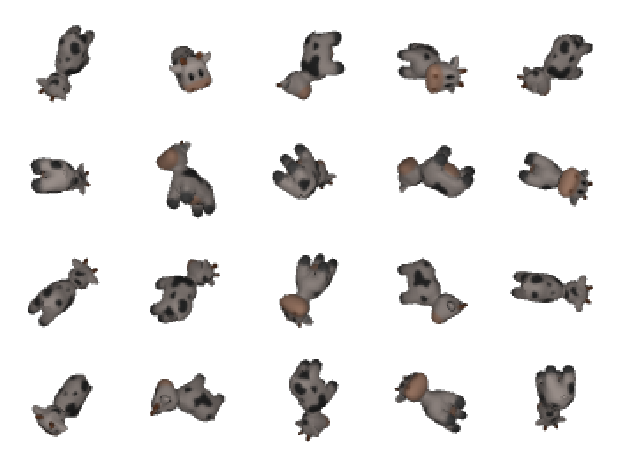

In [6]:
image_grid(ref_colors, rows=4, cols=5, rgb=True)

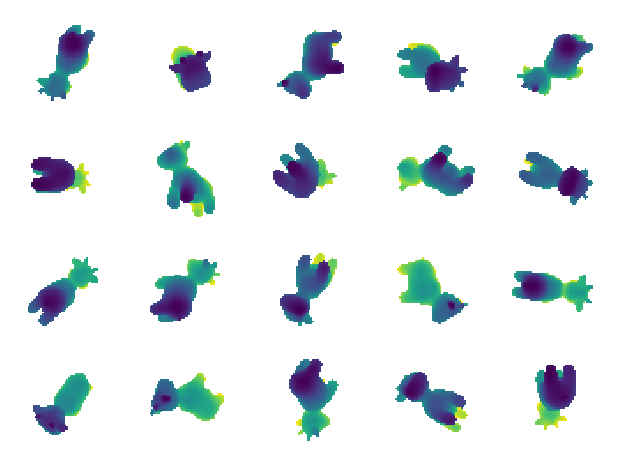

In [7]:
target_sil = (~np.isnan(ref_depths)).astype(np.float32)
image_grid(ref_depths, rows=4, cols=5, rgb=False)

In [8]:
target_depth = np.stack(ref_depths, axis=0)

# Setup Fuzzy Metaball renderer

In [9]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
#jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import fm_render
# when using stds, new settings,
hyperparams = fm_render.hyperparams
NUM_MIXTURE = 40
beta2 = jnp.float32(np.exp(hyperparams[0]))
beta3 = jnp.float32(np.exp(hyperparams[1]))

gmm_init_scale = 1

render_jit = jax.jit(fm_render.render_func_rays)
shape_scale = float(mesh_tri.vertices[0].std(0).mean())*3 

Initialize a Fuzzy Metaballs model from random blobs

In [22]:
rand_mean = center+np.random.multivariate_normal(mean=[0,0,0],cov=1e-2*np.identity(3)*shape_scale,size=NUM_MIXTURE)
rand_weight_log = jnp.log(np.ones(NUM_MIXTURE)/NUM_MIXTURE) + jnp.log(gmm_init_scale)
rand_sphere_size = 30
rand_prec = jnp.array([np.identity(3)*rand_sphere_size/shape_scale for _ in range(NUM_MIXTURE)])

In [23]:


height, width = image_size
K = np.array([[focal_length, 0, cx],[0,focal_length,cy],[0,0,1]])
pixel_list = (np.array(np.meshgrid(np.arange(width),height-np.arange(height)-1,[0]))[:,:,:,0]).reshape((3,-1)).T
camera_rays = (pixel_list - K[:,2])/np.diag(K)
camera_rays[:,-1] = -1
cameras_list = []
for tran,quat in zip(trans,rand_quats):
    R = transforms3d.quaternions.quat2mat(quat)
    camera_rays2 = camera_rays @ R
    t = np.tile(tran[None],(camera_rays2.shape[0],1))
    
    rays_trans = np.stack([camera_rays2,t],1)
    cameras_list.append(rays_trans)

In [12]:
if False:
    import trimesh
    import sklearn.mixture
    pts = trimesh.sample.sample_surface_even(mesh_tri,10000)[0]
    gmm = sklearn.mixture.GaussianMixture(NUM_MIXTURE)
    gmm.fit(pts)
    weights_log = np.log( gmm.weights_) + np.log(gmm_init_scale)
    mean = gmm.means_
    prec = gmm.precisions_cholesky_

In [24]:
alpha_results_rand = []
alpha_results_rand_depth = []
for camera_rays in cameras_list:
    est_depth, est_alpha, est_norm, est_w = render_jit(rand_mean,rand_prec,rand_weight_log,camera_rays,beta2/shape_scale,beta3)
    alpha_results_rand.append(est_alpha.reshape(image_size))
    est_depth = np.array(est_depth)
    est_depth[est_alpha < 0.5] = np.nan
    alpha_results_rand_depth.append(est_depth.reshape(image_size))

Text(0.5, 0.98, 'SFS Fuzzy Metaball Initialization')

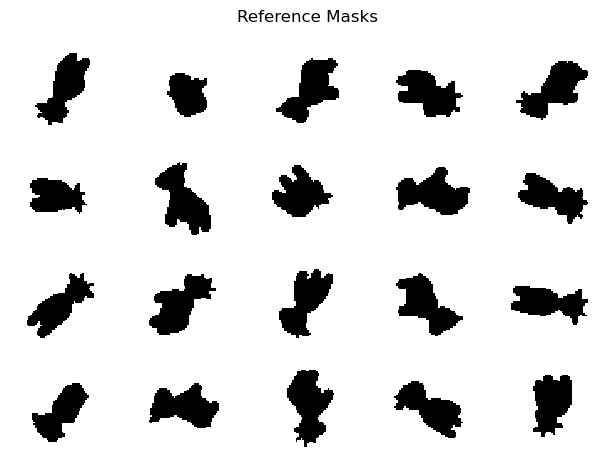

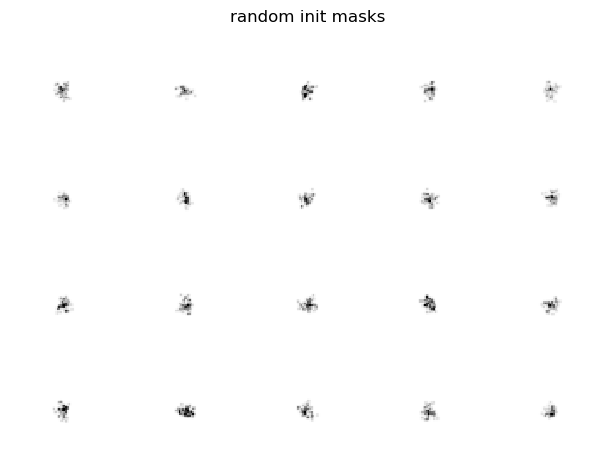

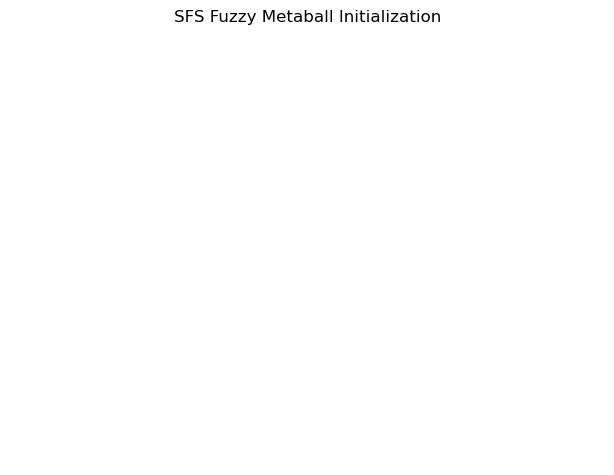

In [25]:
image_grid(target_sil, rows=4, cols=5, rgb=False,cmap='Greys')
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('Reference Masks')
image_grid(alpha_results_rand, rows=4, cols=5, rgb=False,cmap='Greys')
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('random init masks')
image_grid(alpha_results_rand_depth, rows=4, cols=5, rgb=False)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('SFS Fuzzy Metaball Initialization')
#plt.savefig('sfs_init.pdf',facecolor=plt.gcf().get_facecolor(), edgecolor='none',bbox_inches='tight')

# Optimize from a random cloud to a shape

In [26]:
def objective(params,true_alpha):
    CLIP_ALPHA = 3e-8
    means,prec,weights_log,camera_rays,beta2,beta3 = params
    render_res = render_jit(means,prec,weights_log,camera_rays,beta2,beta3)

    est_alpha = render_res[1]
    est_alpha = jnp.clip(est_alpha,CLIP_ALPHA,1-CLIP_ALPHA)
    mask_loss = - ((true_alpha * jnp.log(est_alpha)) + (1-true_alpha)*jnp.log(1-est_alpha))
    return mask_loss.mean()
grad_render3 = jax.jit(jax.value_and_grad(objective))

In [31]:
# Currently not working
def objective_depth(params,true_alpha,true_depth):
    CLIP_ALPHA = 3e-8
    means,prec,weights_log,camera_rays,beta2,beta3 = params
    render_res = render_jit(means,prec,weights_log,camera_rays,beta2,beta3)

    est_depth = render_res[0]
    cond = jnp.isnan(est_depth) | jnp.isnan(true_depth)
    #err = (est_depth - true_depth)/jnp.nan_to_num(true_depth,nan=1)
    err = (est_depth - true_depth)/jnp.nanmean(true_depth)

    depth_loss =  abs(jnp.where(cond,0,err)).mean()

    term1 = depth_loss.mean()

    est_alpha = render_res[1]
    est_alpha = jnp.clip(est_alpha,CLIP_ALPHA,1-CLIP_ALPHA)
    mask_loss = - ((true_alpha * jnp.log(est_alpha)) + (1-true_alpha)*jnp.log(1-est_alpha))

    term2 = mask_loss.mean()
    return 50*term1 + term2

grad_render_depth = jax.jit(jax.value_and_grad(objective_depth))

In [30]:
from jax.example_libraries import optimizers
from util import DegradeLR
def irc(x): return int(round(x))

all_cameras = jnp.array(cameras_list).reshape((-1,2,3))
all_sils = jnp.array(target_sil.ravel()).astype(jnp.float32)
all_depths = jnp.array(target_depth.ravel()).astype(jnp.float32)
opt_tgt = 'depth'

# Number of optimization steps
Nepochs = 10
batch_size = 800
Niter_epoch = int(np.ceil(len(all_cameras)/batch_size))

vecM = jnp.array([[1,1,1],[shape_scale_mul,shape_scale_mul,shape_scale_mul]])[None]

outer_loop = tqdm(range(Nepochs), desc=" epoch", position=0)

adjust_lr = DegradeLR(1e-1,0.5,irc(Niter_epoch*0.4),irc(Niter_epoch*0.1),-1e-4)
opt_init, opt_update, opt_params = optimizers.adam(adjust_lr.step_func)
tmp = [rand_mean*shape_scale_mul,rand_prec/shape_scale_mul,rand_weight_log]
opt_state = opt_init(tmp)


rand_idx = np.arange(len(all_cameras))

losses = []
done = False

for i in outer_loop:
    np.random.shuffle(rand_idx)
    rand_idx_jnp = jnp.array(rand_idx)
    for j in tqdm(range(Niter_epoch), desc=" iteration", position=1, leave=False):
        p = opt_params(opt_state)
        idx = jax.lax.dynamic_slice(rand_idx_jnp,[j*batch_size],[batch_size])

        if opt_tgt == 'sil':
            val,g = grad_render3([p[0],p[1],p[2],vecM*all_cameras[idx],beta2/opt_shape_scale,beta3],all_sils[idx])   
        elif opt_tgt == 'depth':
            val,g = grad_render_depth([p[0],p[1],p[2],vecM*all_cameras[idx],beta2/opt_shape_scale,beta3],all_depths[idx])
        opt_state = opt_update(i, g[:3], opt_state)

        val = float(val)
        losses.append(val)
        outer_loop.set_description("total_loss = %.3f" % val)
        if adjust_lr.add(val):
            done = True
            break
    if done:
        break

 epoch:   0%|          | 0/10 [00:00<?, ?it/s]

 iteration:   0%|          | 0/103 [00:00<?, ?it/s]

NameError: name 'true_alpha' is not defined

In [18]:
final_mean, final_prec, final_weight_log = opt_params(opt_state)
final_mean /= shape_scale_mul
final_prec *= shape_scale_mul

Text(0, 0.5, 'log loss')

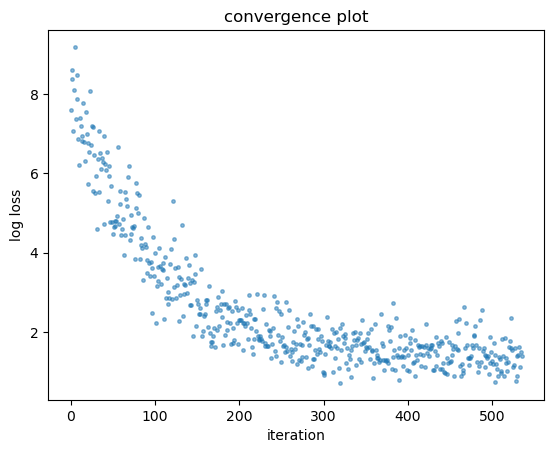

In [19]:
plt.title('convergence plot')
plt.plot(losses,marker='.',lw=0,ms=5,alpha=0.5)
plt.xlabel('iteration')
plt.ylabel('log loss')

# Visualize Results

Text(0.5, 0.98, 'Final masks')

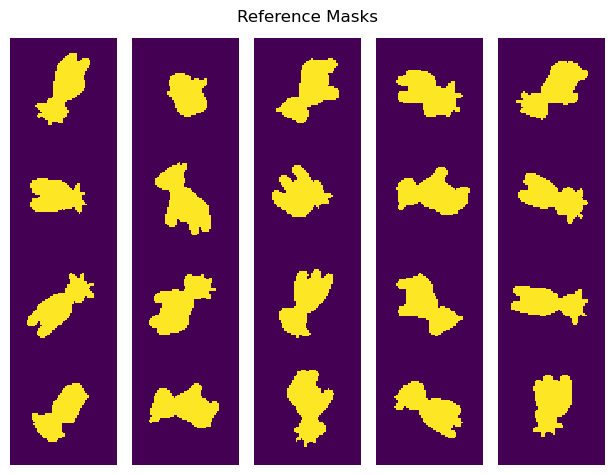

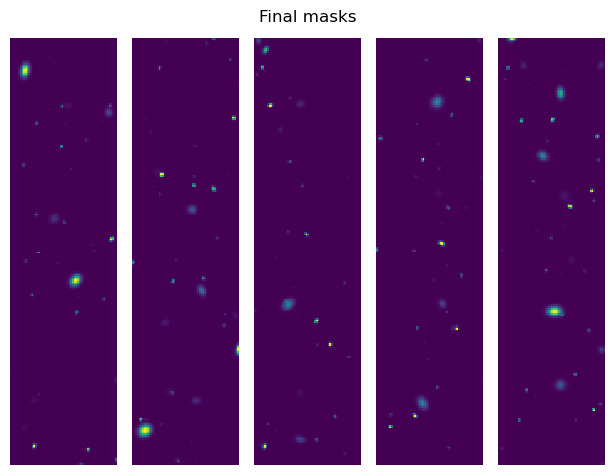

In [20]:
alpha_results_final = []
alpha_results_depth = []
for camera_rays in cameras_list:
    est_depth, est_alpha, est_norms, est_w = render_jit(final_mean,final_prec,final_weight_log,camera_rays,beta2/shape_scale,beta3)
    alpha_results_final.append(est_alpha.reshape(image_size))
    
    est_depth = np.array(est_depth)
    
    est_depth[est_alpha < 0.5] = np.nan
    alpha_results_depth.append(est_depth.reshape(image_size))
image_grid(target_sil, rows=4, cols=5, rgb=False)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('Reference Masks')

image_grid(alpha_results_final, rows=4, cols=5, rgb=False)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('Final masks')

In [ ]:
vmin = np.nanmin(np.array(ref_depths))
vmax = np.nanmax(np.array(ref_depths))
plt.imshow(alpha_results_depth[3],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.figure()
plt.imshow(ref_depths[3],vmin=vmin,vmax=vmax)
plt.colorbar()

In [ ]:
image_grid(alpha_results_depth, rows=4, cols=5, rgb=False,vmin=vmin,vmax=vmax)
plt.gcf().subplots_adjust(top=0.92)
plt.suptitle('SFS results')
plt.tight_layout()
#plt.savefig('sfs_res.pdf',facecolor=plt.gcf().get_facecolor(), edgecolor='none',bbox_inches='tight')

In [ ]:
from numpy import random
points_list = []
colors_list = []
num_sample = 5000

for idx in range(len(final_mean)):
    if final_weight_log[idx] > 0:  # final_weight_log keeps valid balls
        prec = final_prec[idx]  # L^T
        points_list.append(random.multivariate_normal(final_mean[idx], np.linalg.inv(prec.T @ prec), size=num_sample))
        colors = np.stack([np.random.rand(3)] * num_sample, axis=0)
        colors_list.append(colors)
points = np.concatenate(points_list, axis=0)
colors = np.concatenate(colors_list, axis=0)
pcd = np.concatenate([points, colors], axis=1)

In [ ]:
np.savetxt('test.txt', pcd)